### Natural Language Proccessing Project - Detect ChatGPT

In [1]:
# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import spacy

# Utility libraries
from prettytable import PrettyTable
from collections import Counter
import re
import string

# flesch reading ease
from textstat import flesch_reading_ease, flesch_kincaid_grade

# Setting up the environment and importing libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import keras
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l1,l2




2024-05-30 19:19:29.586710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#train_set = pd.read_csv('./data/competetion/train_essays.csv')
#chatgpt_train = pd.read_csv('./data/gpt/daigt_external_dataset.csv')

train_set = pd.read_csv('Data_final.csv')

In [3]:
# Edit these to match our theme (School grading)
colors = ['#FF92FF', '#E68FF2', '#CE8CE6', '#B58AD9', '#9C87CC', '#8484C0', '#6B81B3']

In [4]:
train_set.head(5)

,text,label,prompt,grade,task
0,\nWhen considering the pros and cons of attend...,0,Distance learning,11,Independent
1,"In the wake of the global pandemic, the concep...",1,Distance learning,gpt-4,Independent
2,\nOne of the primary arguments for implementin...,0,Four-day work week,12,Independent
3,The concept of a four-day school week has been...,1,Four-day work week,gpt-4,Independent
4,\nBefore making any decisions about getting in...,0,Controlling extracurricular involvement,11,Independent


### Dataset Description
#### text: Student text or ChatGPT 4 turbo generated text (based on label).
#### label: Label 0 is student essays and label 1 is ChatGPT generated.
#### prompt: Is overall category of the assignment that was given to the students.
#### grade: Grade level of the student or version of ChatGPT.
#### task: Independent means assignment didn't include an external document or other files.

In [5]:
train_set.shape

(3582, 5)

In [6]:
train_set.isna().sum()

text      0
label     0
prompt    0
grade     0
task      0
dtype: int64

### Lets see the distributuon of handwritten student essays and generated essays from ChatGPT

In [7]:
train_set['label'].value_counts()

0    1791
1    1791
Name: label, dtype: int64

### Structure of Dataset Prompts

In [8]:
# Prompts
train_data_values = train_set['prompt'].value_counts()

train_data_values

Distance learning                                 330
Success and failure                               284
Being busy                                        248
Impact of technology                              224
Career commitment                                 210
Positive attitudes                                208
First impressions                                 206
Three-year high school program                    198
Individuality                                     194
Trying something beyond what you have mastered    178
Four-day work week                                172
Working with a group or alone                     170
Self-reliance                                     166
Influences of character                           114
Year-round school                                  76
Cell phones in classrooms                          74
Influencing behavior                               74
Praising student work                              72
Curfews for teenagers       

### 5 most popular prompts

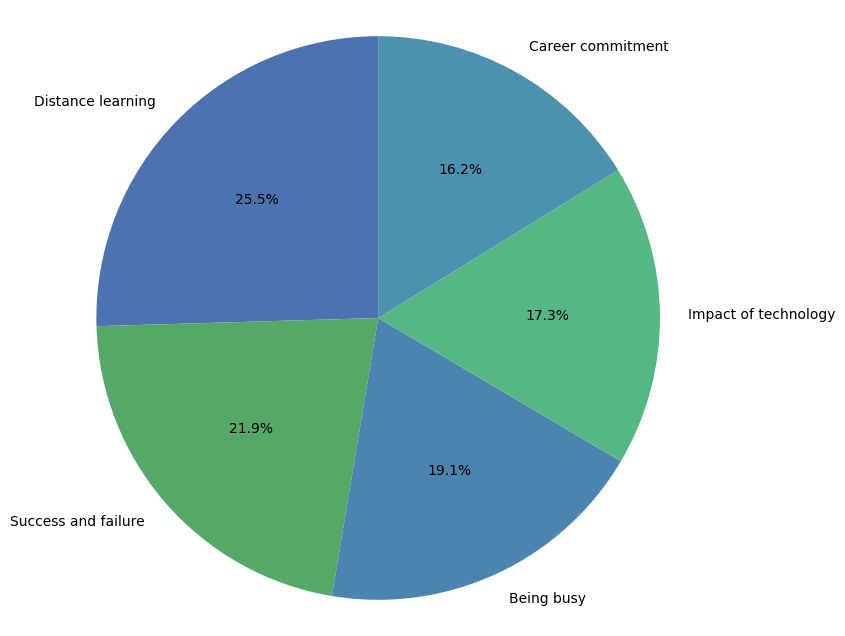

In [9]:
# Get the top 5 most popular prompts
top_5_prompts = train_data_values.head(5)

# Prepare data for the pie chart
labels = top_5_prompts.index
sizes = top_5_prompts.values

# Colors
colors = ['#4C72B0', '#55A868', '#4C84B0', '#55B884', '#4C92B0']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/3436020828.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prompt_titles_count.values, y=prompt_titles_count.index, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/3436020828.py:4: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=prompt_titles_count.values, y=prompt_titles_count.index, palette=colors)


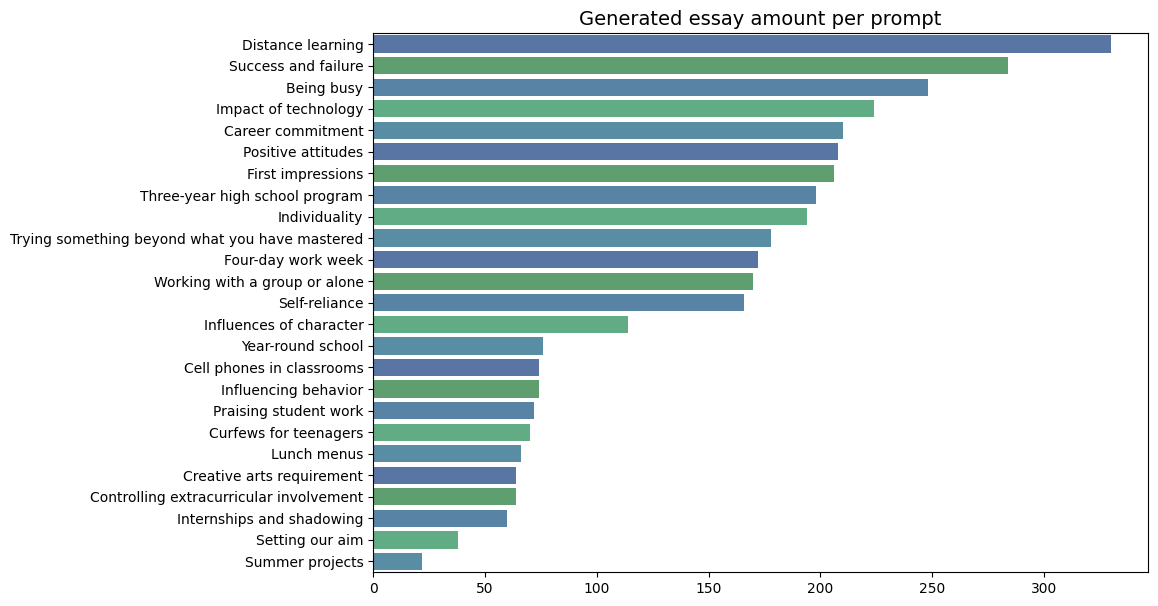

In [10]:
prompt_titles_count = train_set['prompt'].value_counts()

plt.figure(figsize=(10, 7))
sns.barplot(x=prompt_titles_count.values, y=prompt_titles_count.index, palette=colors)
plt.title('Generated essay amount per prompt', fontsize=14)
plt.ylabel('')
plt.show()

### We will now split the train set based on label so we can get a sense of how the differ.

In [11]:
# Split the DataFrame based on the 'label' column
train_student = train_set[train_set['label'] == 0]
train_gpt = train_set[train_set['label'] == 1]

### First we wan't to compare text length of handwritten student essays and gpt generated
The below graphs give us insights about the distribution of the amount of characters, words and sentences.

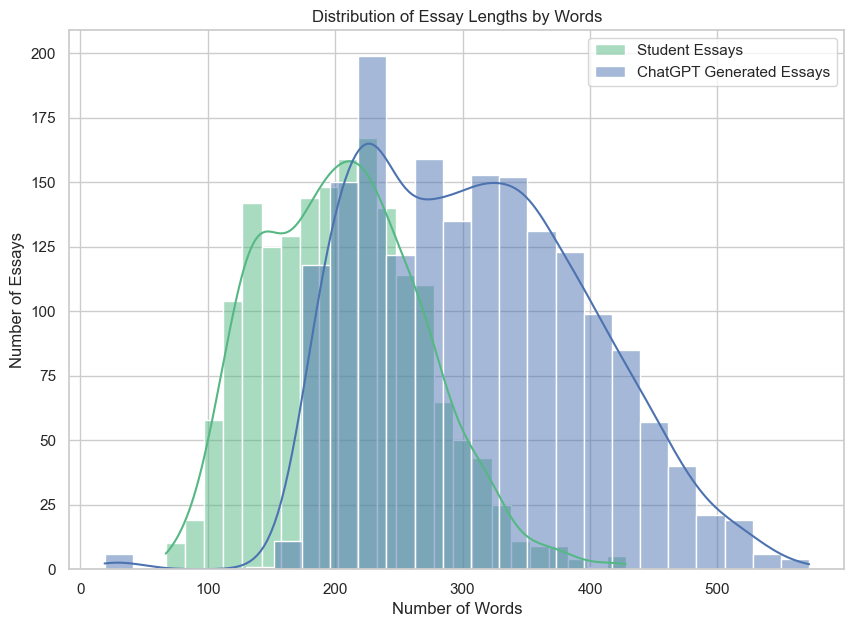

In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

student_train_word_count = train_student['text'].apply(lambda x: len(x.split()))
gpt_train_word_count = train_gpt['text'].apply(lambda x: len(x.split()))

sns.histplot(student_train_word_count, color=colors[3], label='Student Essays', kde=True)
sns.histplot(gpt_train_word_count, color=colors[0], label='ChatGPT Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths by Words')
plt.xlabel('Number of Words')
plt.ylabel('Number of Essays')
plt.legend()
plt.show()

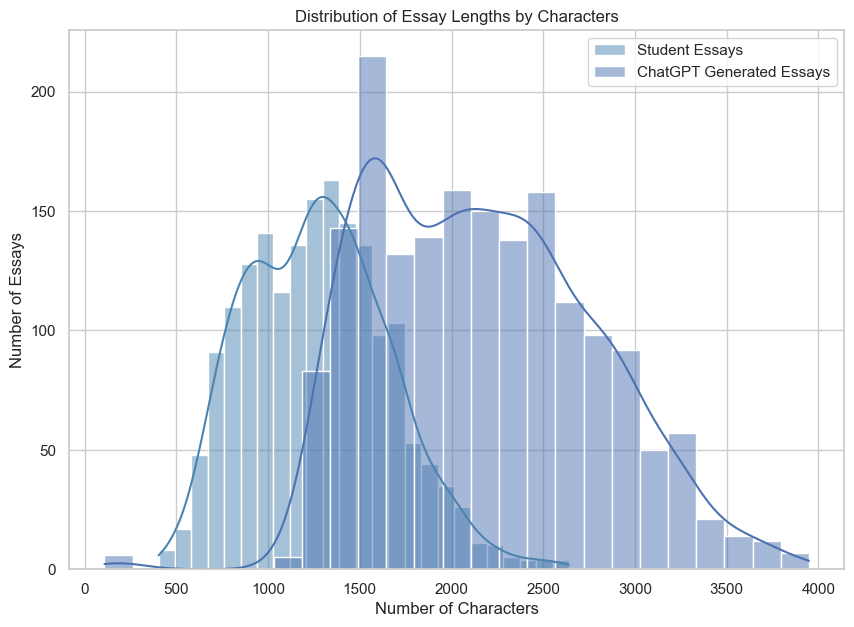

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

sns.histplot(train_student['text'].apply(len), color=colors[2], label='Student Essays', kde=True)
sns.histplot(train_gpt['text'].apply(len), color=colors[0], label='ChatGPT Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths by Characters')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Essays')
plt.legend()
plt.show()

### Next, we'll calculate the average characters, words, and sentences per essay by tokenizing the text and using helper functions for processing.

In [14]:
# Helper functions
def annotate_bars(ax):
    """Annotate bars with their height values."""
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 10), 
                    textcoords='offset points',
                    ha='center', 
                    va='center')

def plot_annotated_bar(ax, data, label_mapping, title):
    """Plot a bar chart with annotated bars."""
    ax.bar(data.index.map(label_mapping), data, color=colors)
    ax.set_title(title, fontsize=14)
    annotate_bars(ax)

In [15]:
# Ensure necessary NLTK data is downloaded
# nltk.download('punkt')

# Calculate character, word, and sentence counts for each text
train_student['character_count'] = train_student['text'].str.len()
train_student['word_count'] = train_student['text'].apply(lambda x: len(word_tokenize(x)))
train_student['sentence_count'] = train_student['text'].apply(lambda x: len(sent_tokenize(x)))

# Compute average counts by prompt_id
average_counts = train_student.groupby('prompt').agg({
    'character_count': 'mean',
    'word_count': 'mean',
    'sentence_count': 'mean'
}).reset_index()

student_avg_character_counts = average_counts[['prompt', 'character_count']]
student_avg_word_counts = average_counts[['prompt', 'word_count']]
student_avg_sentence_counts = average_counts[['prompt', 'sentence_count']]


/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/581946616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_student['character_count'] = train_student['text'].str.len()
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/581946616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_student['word_count'] = train_student['text'].apply(lambda x: len(word_tokenize(x)))
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/581946616.py:7: SettingWithCopyWarn

In [16]:
# Calculate character, word, and sentence counts for each text
train_gpt['character_count'] = train_gpt['text'].str.len()
train_gpt['word_count'] = train_gpt['text'].apply(lambda x: len(word_tokenize(x)))
train_gpt['sentence_count'] = train_gpt['text'].apply(lambda x: len(sent_tokenize(x)))

# Compute average counts by prompt_name
average_counts = train_gpt.groupby('prompt').agg({
    'character_count': 'mean',
    'word_count': 'mean',
    'sentence_count': 'mean'
}).reset_index()

chatgpt_average_character_counts = average_counts[['prompt', 'character_count']]
chatgpt_average_word_counts = average_counts[['prompt', 'word_count']]
chatgpt_average_sentence_counts = average_counts[['prompt', 'sentence_count']]


/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/2494345299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_gpt['character_count'] = train_gpt['text'].str.len()


/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/2494345299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_gpt['word_count'] = train_gpt['text'].apply(lambda x: len(word_tokenize(x)))
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/2494345299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_gpt['sentence_count'] = train_gpt['text'].apply(lambda x: len(sent_tokenize(x)))


In [17]:
average_values = pd.DataFrame({
    'Source': ['Student Train', 'ChatGPT Train'],
    'Avg Chars': [round(train_student['character_count'].mean(), 2), round(train_gpt['character_count'].mean(), 2)],
    'Avg Words': [round(train_student['word_count'].mean(), 2), round(train_gpt['word_count'].mean(), 2)],
    'Avg Sentences': [round(train_student['sentence_count'].mean(), 2), round(train_gpt['sentence_count'].mean(), 2)]
})

table = PrettyTable()
table.field_names = average_values.columns.tolist()

for _, row in average_values.iterrows():
    table.add_row(row.tolist())

table

Source,Avg Chars,Avg Words,Avg Sentences
Student Train,1272.87,228.5,9.62
ChatGPT Train,2163.92,349.73,13.93


### Summary for ChatGPT Generated

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/4166440317.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='prompt', y='word_count', data=chatgpt_average_word_counts, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/4166440317.py:2: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='prompt', y='word_count', data=chatgpt_average_word_counts, palette=colors)


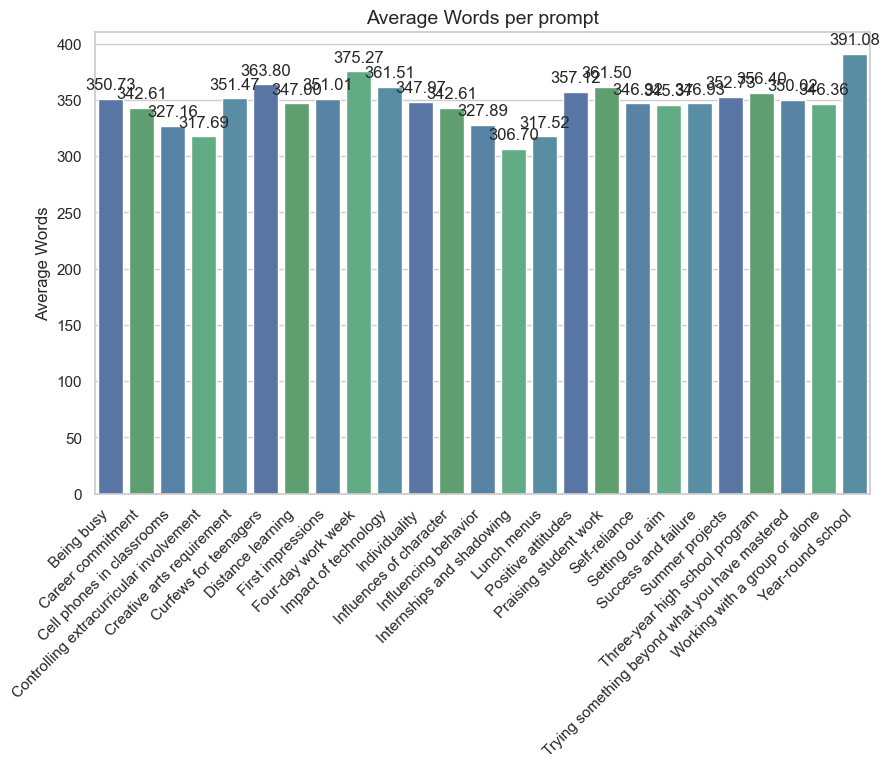

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='prompt', y='word_count', data=chatgpt_average_word_counts, palette=colors)
plt.title('Average Words per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Words')
plt.xticks(rotation=45, ha='right')
annotate_bars(ax)
plt.show()

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/2972543437.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='prompt', y='character_count', data=chatgpt_average_character_counts, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/2972543437.py:2: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='prompt', y='character_count', data=chatgpt_average_character_counts, palette=colors)


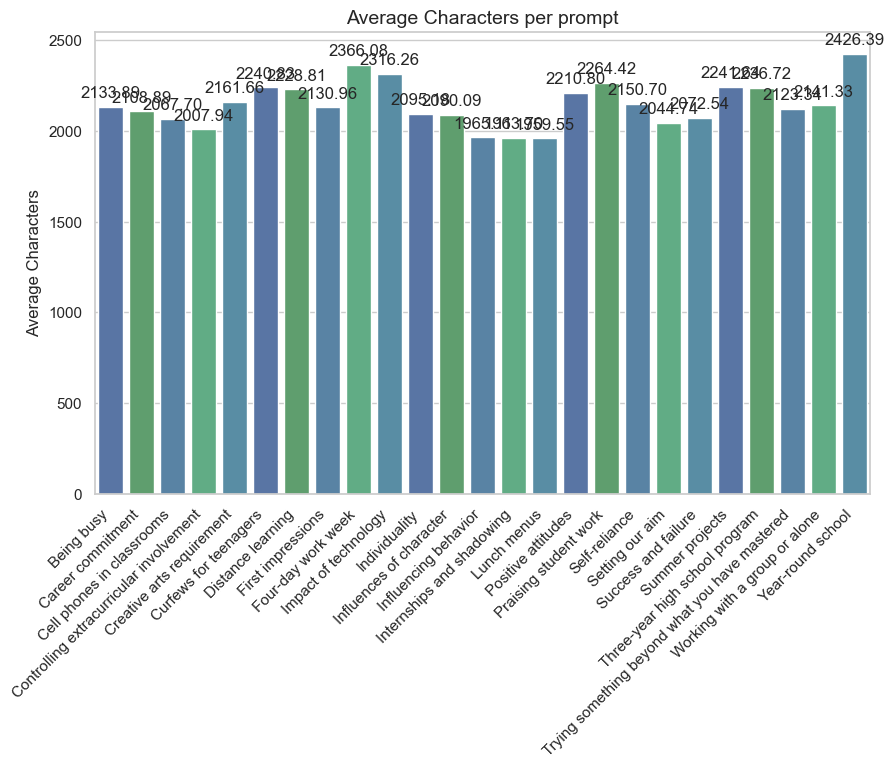

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='prompt', y='character_count', data=chatgpt_average_character_counts, palette=colors)
plt.title('Average Characters per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Characters')
plt.xticks(rotation=45, ha='right')
annotate_bars(ax)
plt.show()

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/3792731691.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='prompt', y='sentence_count', data=chatgpt_average_sentence_counts, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/3792731691.py:2: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='prompt', y='sentence_count', data=chatgpt_average_sentence_counts, palette=colors)


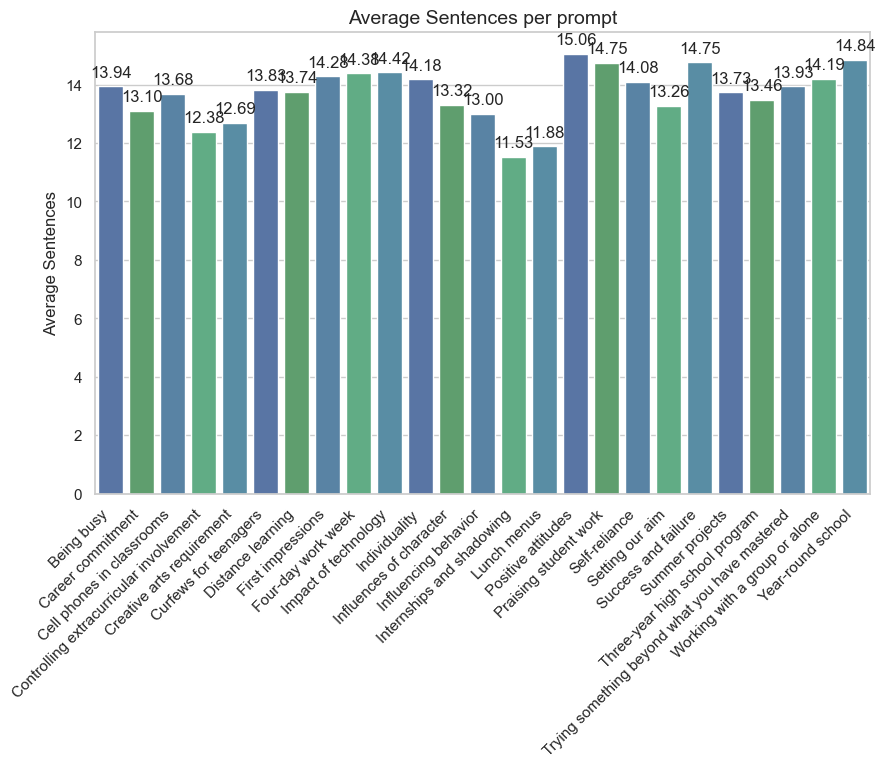

In [20]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='prompt', y='sentence_count', data=chatgpt_average_sentence_counts, palette=colors)
plt.title('Average Sentences per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Sentences')
plt.xticks(rotation=45, ha='right')
annotate_bars(ax)
plt.show()

### And for the student dataset

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/1228872702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='prompt', y='word_count', data=student_avg_word_counts, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/1228872702.py:2: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='prompt', y='word_count', data=student_avg_word_counts, palette=colors)


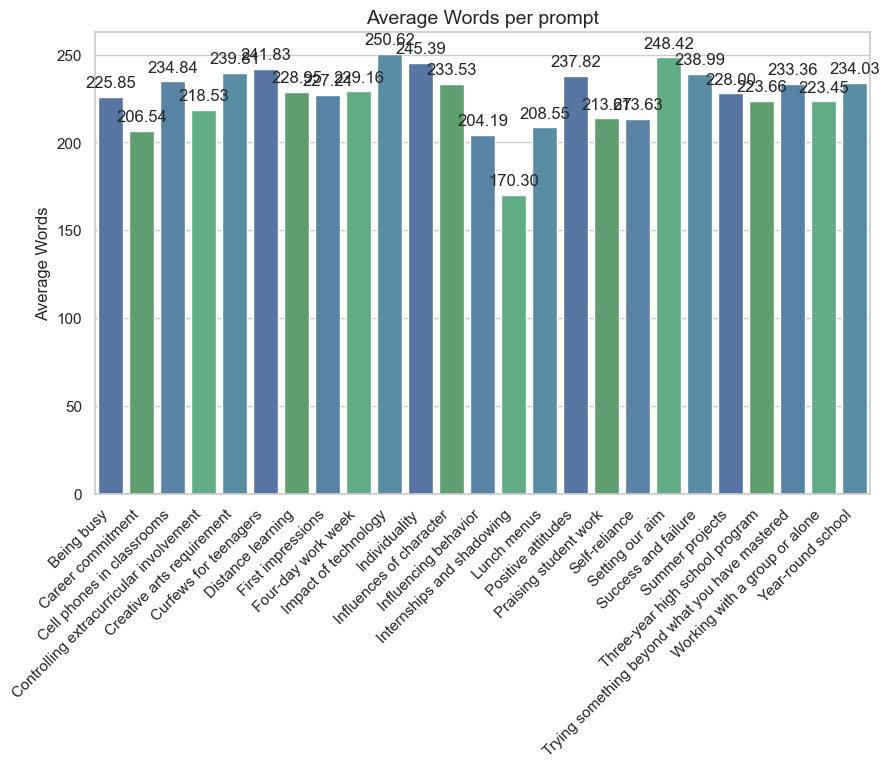

In [21]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='prompt', y='word_count', data=student_avg_word_counts, palette=colors)
plt.title('Average Words per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Words')
plt.xticks(rotation=45, ha='right')
annotate_bars(ax)
plt.show()

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/3926976426.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='prompt', y='character_count', data=student_avg_character_counts, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/3926976426.py:2: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='prompt', y='character_count', data=student_avg_character_counts, palette=colors)


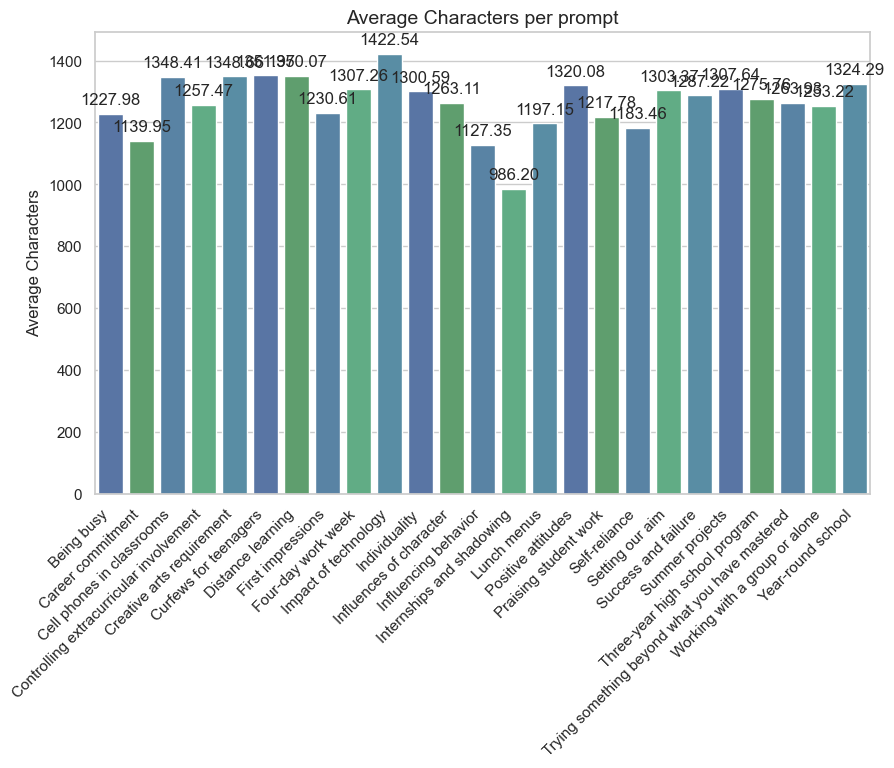

In [22]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='prompt', y='character_count', data=student_avg_character_counts, palette=colors)
plt.title('Average Characters per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Characters')
plt.xticks(rotation=45, ha='right')
annotate_bars(ax)
plt.show()

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/2492513966.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='prompt', y='sentence_count', data=student_avg_sentence_counts, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/2492513966.py:2: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='prompt', y='sentence_count', data=student_avg_sentence_counts, palette=colors)


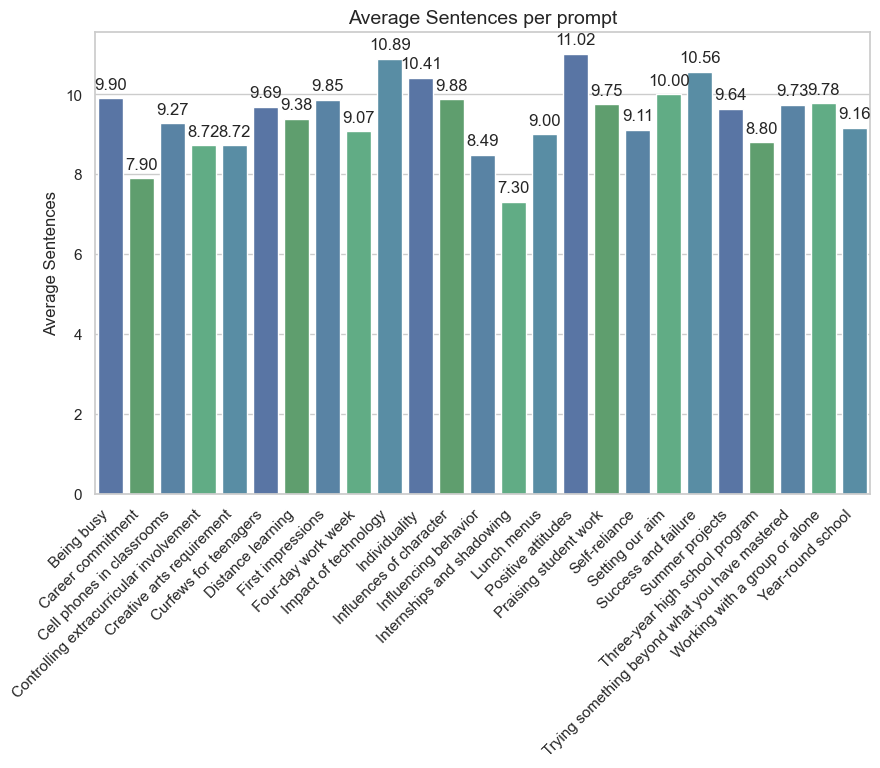

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='prompt', y='sentence_count', data=student_avg_sentence_counts, palette=colors)
plt.title('Average Sentences per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Sentences')
plt.xticks(rotation=45, ha='right')
annotate_bars(ax)
plt.show()

### Unique Words

In [24]:
student_unique_words = set(train_student['text'].str.split().explode())
chatgpt_train_unique_words = set(train_gpt['text'].str.split().explode())

table = PrettyTable(['Dataset', 'Amount of Unique Words'])
table.add_row(['Student Essays', len(student_unique_words)])
table.add_row(['ChatGPT Generated Essays', len(chatgpt_train_unique_words)])

table

Dataset,Amount of Unique Words
Student Essays,16714
ChatGPT Generated Essays,23197


### Common Words Analysis
Next, we will compare the 20 most frequently used words in both types of essays.

In [25]:
def most_frequent_words(data, n=20):
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    word_matrix = vectorizer.fit_transform(data['text'])
    word_freq = pd.DataFrame(word_matrix.sum(axis=0), columns=vectorizer.get_feature_names_out())
    common_words = word_freq.transpose().sort_values(by=0, ascending=False).head(n)
    return common_words

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/212995730.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_common_words[0], y=train_common_words.index, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/212995730.py:7: UserWarning: 
The palette list has fewer values (5) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=train_common_words[0], y=train_common_words.index, palette=colors)
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/212995730.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chatgpt_train_common_words[0], y=chatgpt_train_common_words.index, palette=color

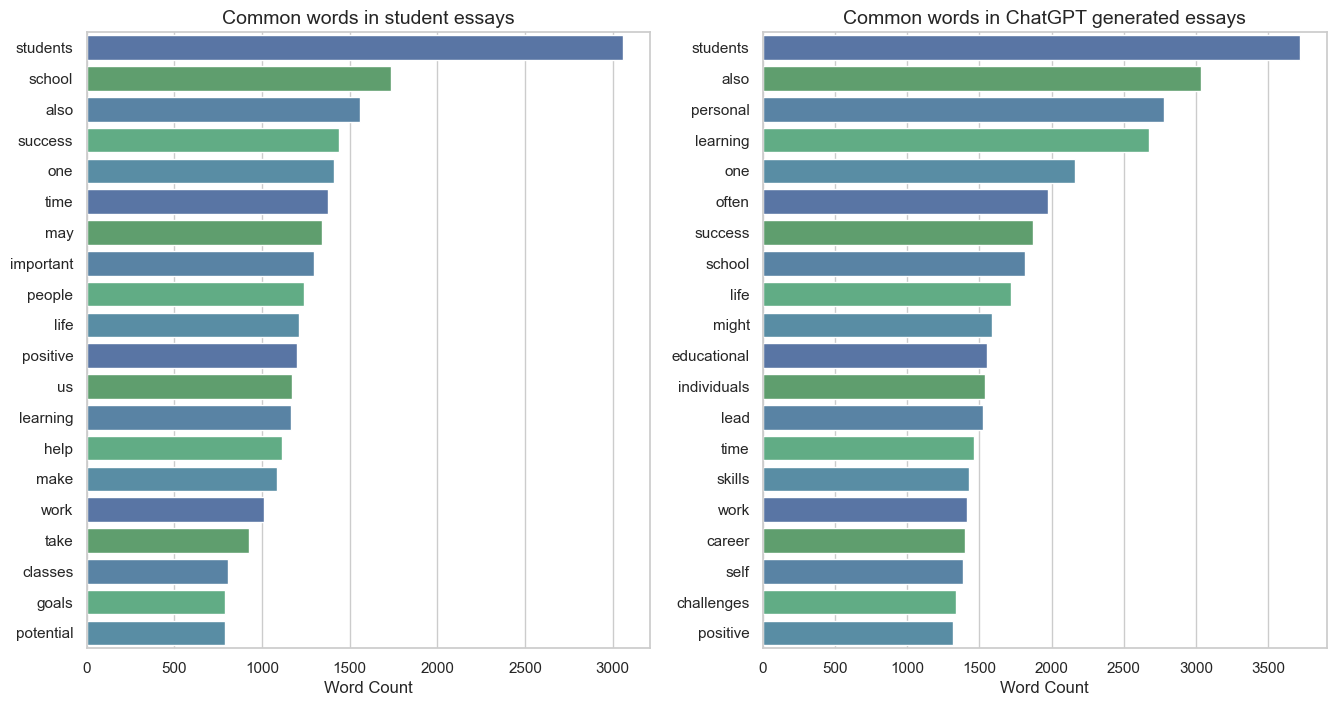

In [26]:
train_common_words = most_frequent_words(train_student)
chatgpt_train_common_words = most_frequent_words(train_gpt)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=train_common_words[0], y=train_common_words.index, palette=colors)
plt.title('Common words in student essays', fontsize=14)
plt.xlabel('Word Count')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.barplot(x=chatgpt_train_common_words[0], y=chatgpt_train_common_words.index, palette=colors)
plt.title('Common words in ChatGPT generated essays', fontsize=14)
plt.xlabel('Word Count')
plt.ylabel('')

plt.show()

### Special Characters
We'll examine special characters to understand the noise in handwritten vs. ChatGPT generated essays.

In [27]:
def generate_special_characters_table(df, text_column='text'):
    special_characters = [c for text in df[text_column] for c in text 
                          if not (c.isalnum() or c.isspace())]
    character_counts = Counter(special_characters)
    table = PrettyTable(['Special Character', 'Count'])

    for char, count in character_counts.items():
        table.add_row([char, count])

    table.sortby = 'Count'
    table.reversesort = True

    return table

In [28]:
generate_special_characters_table(train_student)

Special Character,Count
",",19752
.,17358
-,2533
',1393
’,799
"""",281
;,224
“,179
”,178
:,154


In [29]:
generate_special_characters_table(train_gpt)

Special Character,Count
",",38200
.,25178
-,5695
',2695
’,1303
"""",629
;,497
—,387
:,122
),64


### EDA

Now we have been looking into differences between the set, now its time to do some EDA.
We will use the original set again.

In [30]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

train_set['text'] = train_set['text'].apply(remove_stopwords)
train_gpt.sample(5)

,text,label,prompt,grade,task,character_count,word_count,sentence_count
3281,The advent of technology has significantly tra...,1,Impact of technology,gpt-4,Independent,2556,395,16
673,Implementing a mandate where all high school s...,1,Three-year high school program,gpt-4,Independent,3271,508,21
2255,"Implementing a four-day school week, with an e...",1,Four-day work week,gpt-4,Independent,1387,218,9
451,Committing to a career at a young age can be b...,1,Career commitment,gpt-4,Independent,1922,319,13
73,The notion that the greatest accomplishment is...,1,Individuality,gpt-4,Independent,2519,413,17


In [31]:
train_set.describe()

,label
count,3582.00000
mean,0.50000
std,0.50007
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


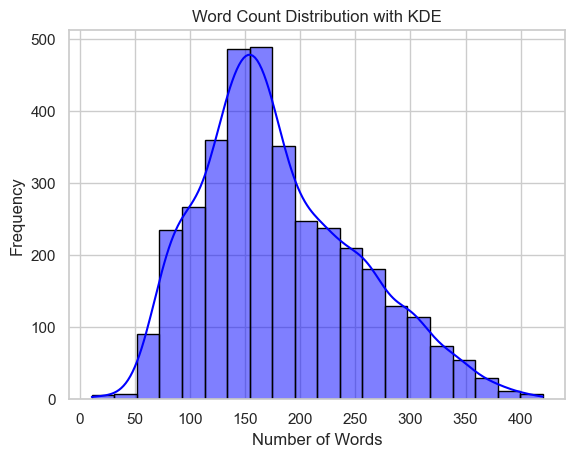

In [32]:
word_counts = train_set["text"].apply(lambda x: len(x.split()))

# Plot histogram with KDE
sns.histplot(word_counts, bins=20, kde=True, color='blue', edgecolor='black')
plt.title('Word Count Distribution with KDE')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Ngram exploration

In [33]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/276211175.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_text_by_humans = total_text_values[train_set['label'] == 0]
/var/folders/bh/6855mw210qx29tsk6znjstw40000gn/T/ipykernel_30061/276211175.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_text_by_chatgpt = total_text_values[train_set['label'] == 1]


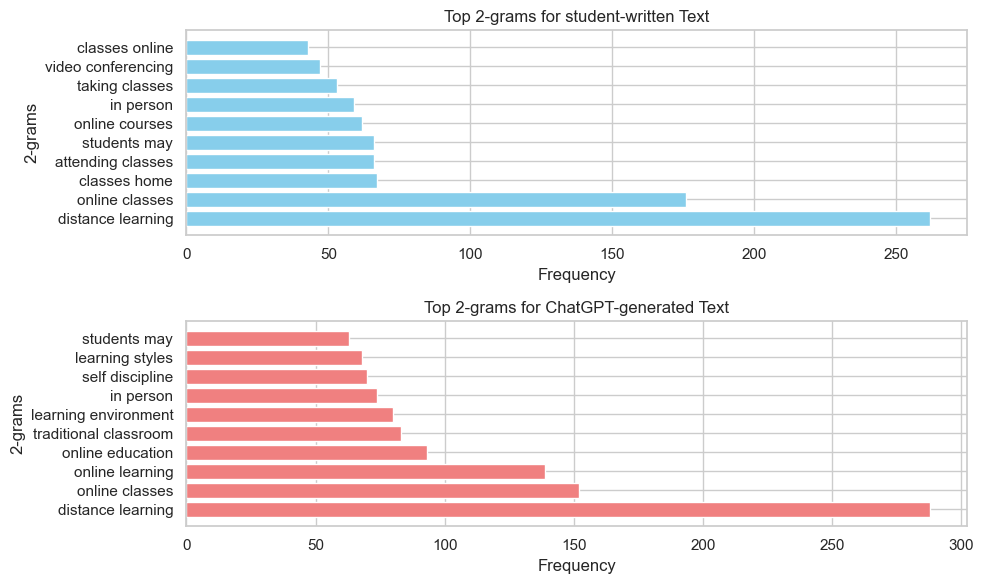

In [34]:
#Filter the dataset for the prompt "Distance Learning"
total_text_values = train_set[train_set['prompt'] == "Distance learning"]

#Seperate human and chatgpt generated
df_text_by_humans = total_text_values[train_set['label'] == 0]
df_text_by_chatgpt = total_text_values[train_set['label'] == 1]

# Ngrams for non-generated text (label 0)
top_n_bigrams = get_top_ngram(df_text_by_humans['text'], 2) # 4-gram
x, y = map(list, zip(*top_n_bigrams)) 

# Ngrams for generated text (label 1)
top_n_bigrams_gpt = get_top_ngram(df_text_by_chatgpt['text'], 2) # 4-gram
x_gpt, y_gpt = map(list, zip(*top_n_bigrams_gpt)) 

# Plotting side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Non-generated text bigrams
axes[0].barh(x, y, color='skyblue')
axes[0].set_title('Top 2-grams for student-written Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('2-grams')

# Generated text bigrams
axes[1].barh(x_gpt, y_gpt, color='lightcoral')
axes[1].set_title('Top 2-grams for ChatGPT-generated Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('2-grams')

plt.tight_layout()
plt.show()

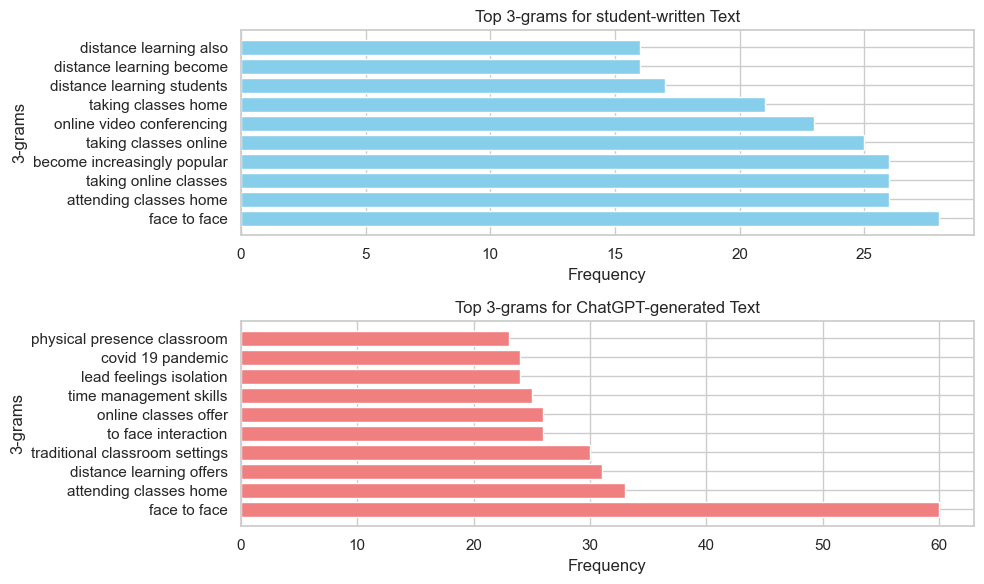

In [35]:
# Ngrams for non-generated text (label 0)
top_n_bigrams = get_top_ngram(df_text_by_humans['text'], 3) # 4-gram
x, y = map(list, zip(*top_n_bigrams)) 

# Ngrams for generated text (label 1)
top_n_bigrams_gpt = get_top_ngram(df_text_by_chatgpt['text'], 3) # 4-gram
x_gpt, y_gpt = map(list, zip(*top_n_bigrams_gpt)) 

# Plotting side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Non-generated text bigrams
axes[0].barh(x, y, color='skyblue')
axes[0].set_title('Top 3-grams for student-written Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('3-grams')

# Generated text bigrams
axes[1].barh(x_gpt, y_gpt, color='lightcoral')
axes[1].set_title('Top 3-grams for ChatGPT-generated Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('3-grams')

plt.tight_layout()
plt.show()

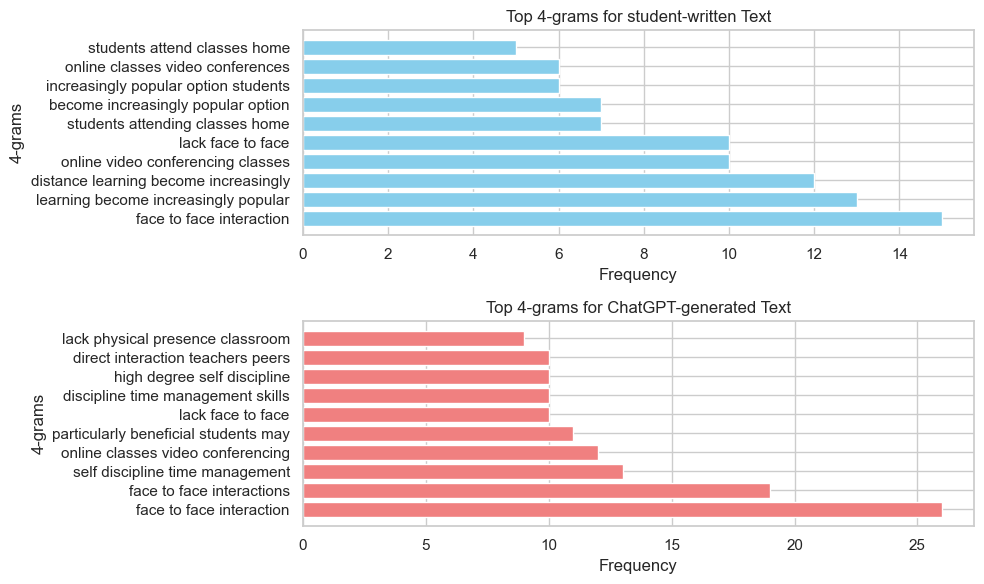

In [36]:
import matplotlib.pyplot as plt

# Ngrams for non-generated text (label 0)
top_n_bigrams = get_top_ngram(df_text_by_humans['text'], 4) # 4-gram
x, y = map(list, zip(*top_n_bigrams)) 

# Ngrams for generated text (label 1)
top_n_bigrams_gpt = get_top_ngram(df_text_by_chatgpt['text'], 4) # 4-gram
x_gpt, y_gpt = map(list, zip(*top_n_bigrams_gpt)) 

# Plotting side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Non-generated text bigrams
axes[0].barh(x, y, color='skyblue')
axes[0].set_title('Top 4-grams for student-written Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('4-grams')

# Generated text bigrams
axes[1].barh(x_gpt, y_gpt, color='lightcoral')
axes[1].set_title('Top 4-grams for ChatGPT-generated Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('4-grams')

plt.tight_layout()
plt.show()


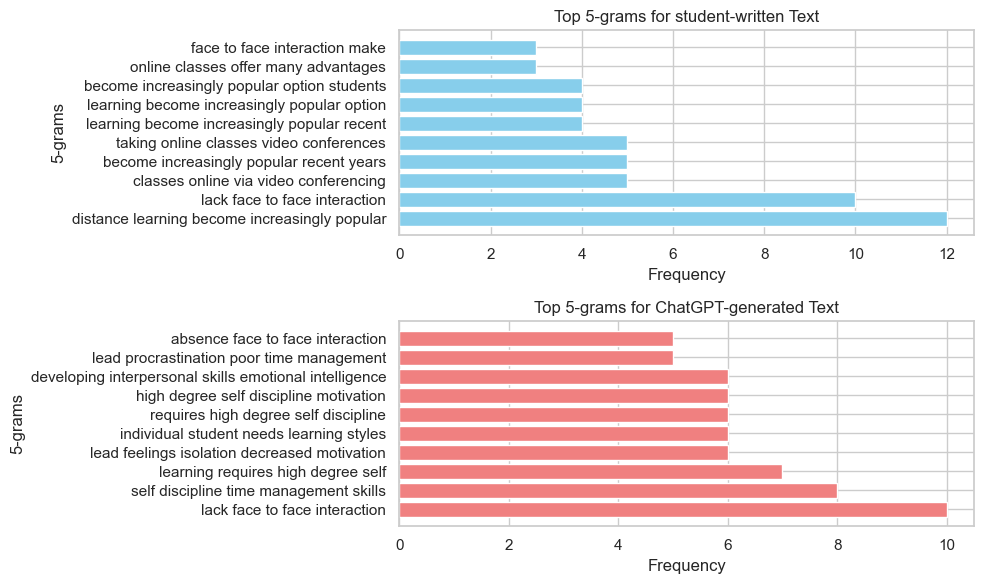

In [37]:
import matplotlib.pyplot as plt

# Ngrams for non-generated text (label 0)
top_n_bigrams = get_top_ngram(df_text_by_humans['text'], 5) # 4-gram
x, y = map(list, zip(*top_n_bigrams)) 

# Ngrams for generated text (label 1)
top_n_bigrams_gpt = get_top_ngram(df_text_by_chatgpt['text'], 5) # 4-gram
x_gpt, y_gpt = map(list, zip(*top_n_bigrams_gpt)) 

# Plotting side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Non-generated text bigrams
axes[0].barh(x, y, color='skyblue')
axes[0].set_title('Top 5-grams for student-written Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('5-grams')

# Generated text bigrams
axes[1].barh(x_gpt, y_gpt, color='lightcoral')
axes[1].set_title('Top 5-grams for ChatGPT-generated Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('5-grams')

plt.tight_layout()
plt.show()

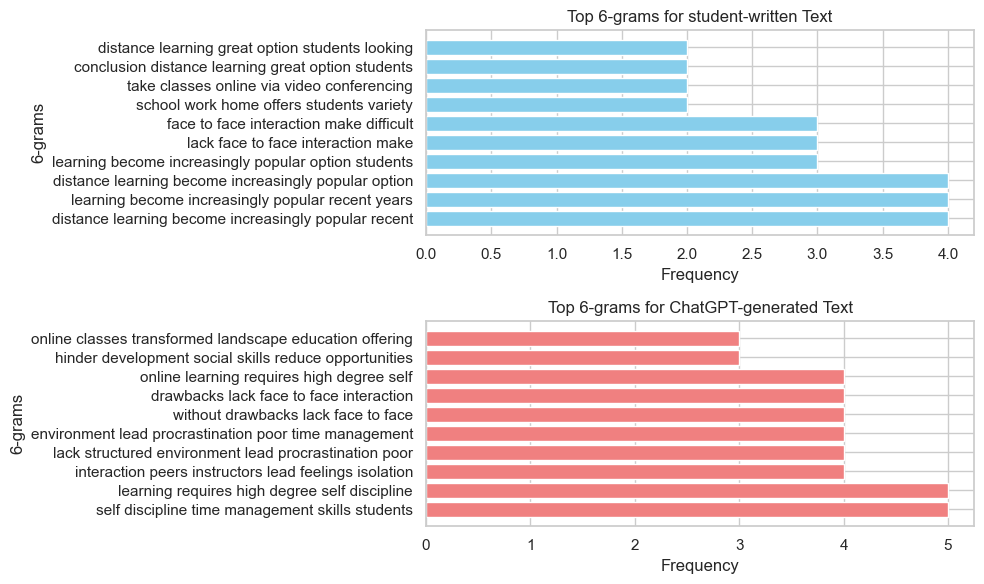

In [38]:
# Ngrams for non-generated text (label 0)
top_n_bigrams = get_top_ngram(df_text_by_humans['text'], 6) # 4-gram
x, y = map(list, zip(*top_n_bigrams)) 

# Ngrams for generated text (label 1)
top_n_bigrams_gpt = get_top_ngram(df_text_by_chatgpt['text'], 6) # 4-gram
x_gpt, y_gpt = map(list, zip(*top_n_bigrams_gpt)) 

# Plotting side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Non-generated text bigrams
axes[0].barh(x, y, color='skyblue')
axes[0].set_title('Top 6-grams for student-written Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('6-grams')

# Generated text bigrams
axes[1].barh(x_gpt, y_gpt, color='lightcoral')
axes[1].set_title('Top 6-grams for ChatGPT-generated Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('6-grams')

plt.tight_layout()
plt.show()

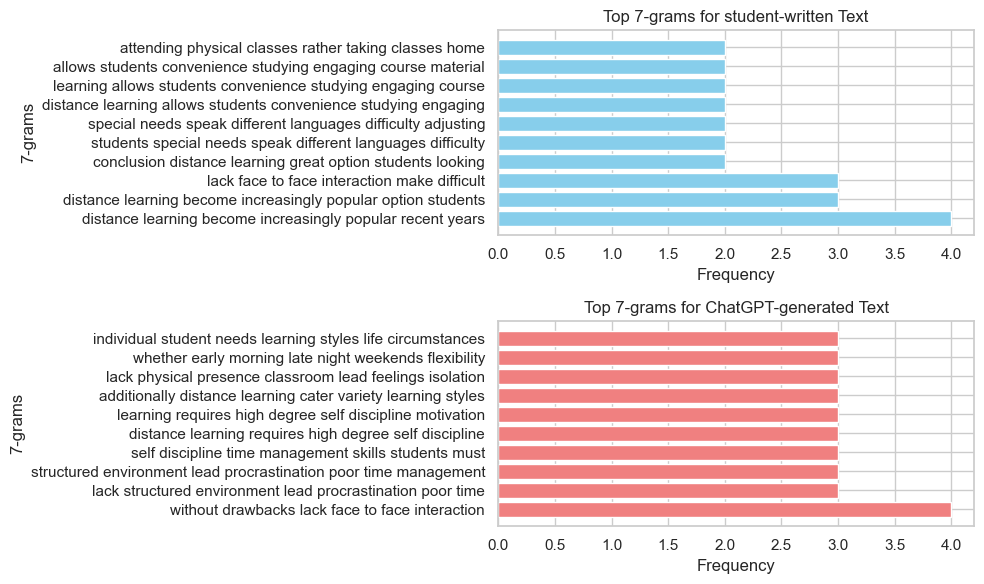

In [39]:
# Ngrams for non-generated text (label 0)
top_n_bigrams = get_top_ngram(df_text_by_humans['text'], 7) # 4-gram
x, y = map(list, zip(*top_n_bigrams)) 

# Ngrams for generated text (label 1)
top_n_bigrams_gpt = get_top_ngram(df_text_by_chatgpt['text'], 7) # 4-gram
x_gpt, y_gpt = map(list, zip(*top_n_bigrams_gpt)) 

# Plotting side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Non-generated text bigrams
axes[0].barh(x, y, color='skyblue')
axes[0].set_title('Top 7-grams for student-written Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('7-grams')

# Generated text bigrams
axes[1].barh(x_gpt, y_gpt, color='lightcoral')
axes[1].set_title('Top 7-grams for ChatGPT-generated Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('7-grams')

plt.tight_layout()
plt.show()

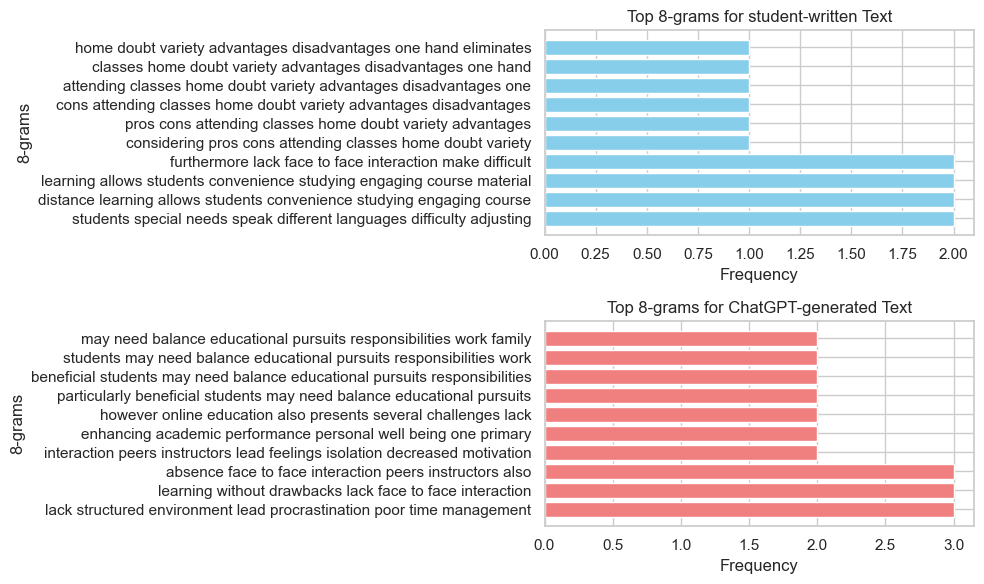

In [40]:
# Ngrams for non-generated text (label 0)
top_n_bigrams = get_top_ngram(df_text_by_humans['text'], 8) # 4-gram
x, y = map(list, zip(*top_n_bigrams)) 

# Ngrams for generated text (label 1)
top_n_bigrams_gpt = get_top_ngram(df_text_by_chatgpt['text'], 8) # 4-gram
x_gpt, y_gpt = map(list, zip(*top_n_bigrams_gpt)) 

# Plotting side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Non-generated text bigrams
axes[0].barh(x, y, color='skyblue')
axes[0].set_title('Top 8-grams for student-written Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('8-grams')

# Generated text bigrams
axes[1].barh(x_gpt, y_gpt, color='lightcoral')
axes[1].set_title('Top 8-grams for ChatGPT-generated Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('8-grams')

plt.tight_layout()
plt.show()

## Type Token Ratio in NLP

In [41]:
df_text_by_humans.describe()

,label
count,165.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


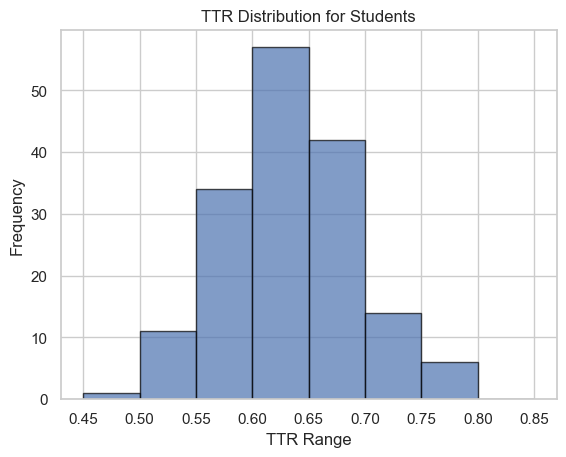

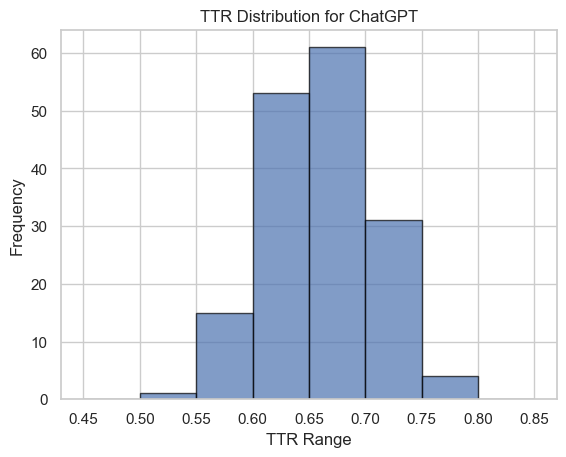

In [42]:
def compute_ttr_ngrams(data, n=3):
    ttr_values = []
    for _, record in data.iterrows():
        text = record['text']
        text_tokens = nltk.word_tokenize(text.lower())
        ngram_text = list(nltk.ngrams(text_tokens, n))
        
        unique_ngrams = set(ngram_text)  # create a set of unique n-grams
        
        if len(ngram_text) == 0:
            ttr_values.append(0)  # Append 0 for TTR if there are no n-grams
            print('none')
        else:
            ttr = len(unique_ngrams) / len(ngram_text)
            ttr_values.append(ttr)
    
    return ttr_values

def plot_histogram(ttr_values, title):
    # Define bins from 0 to 1 in intervals of 0.1
    bins = np.arange(0.45, 0.9, 0.05)
    plt.hist(ttr_values, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('TTR Range')
    plt.ylabel('Frequency')
    plt.xticks(bins)
    plt.show()

# Compute TTR values
humans_ttr = compute_ttr_ngrams(df_text_by_humans, n=1)
chatgpt_ttr = compute_ttr_ngrams(df_text_by_chatgpt, n=1)

# Plot histograms
plot_histogram(humans_ttr, "TTR Distribution for Students")
plot_histogram(chatgpt_ttr, "TTR Distribution for ChatGPT")

In [43]:
'''
Lad være med at slette det her. 

def compute_avg_ttr_ngrams(data, n=2):
    ttr_values = []
    for _, record in data.iterrows():
        text = record['text']
        text_tokens = nltk.word_tokenize(text.lower())
        ngram_text = list(ngrams(text_tokens, n))
        
        unique_ngrams = set(ngram_text)  # create a set of unique n-grams
        
        if len(ngram_text) == 0:
            ttr_values.append(0)  # Append 0 for TTR if there are no n-grams
            print('none')
        else:
            ttr = len(unique_ngrams) / len(ngram_text)
            ttr_values.append(ttr)
    
    avg_ttr = np.mean(ttr_values) if ttr_values else 0  # Calculate average TTR
    return avg_ttr  # Return the average TTR value
'''

"\nLad være med at slette det her. \n\ndef compute_avg_ttr_ngrams(data, n=2):\n    ttr_values = []\n    for _, record in data.iterrows():\n        text = record['text']\n        text_tokens = nltk.word_tokenize(text.lower())\n        ngram_text = list(ngrams(text_tokens, n))\n        \n        unique_ngrams = set(ngram_text)  # create a set of unique n-grams\n        \n        if len(ngram_text) == 0:\n            ttr_values.append(0)  # Append 0 for TTR if there are no n-grams\n            print('none')\n        else:\n            ttr = len(unique_ngrams) / len(ngram_text)\n            ttr_values.append(ttr)\n    \n    avg_ttr = np.mean(ttr_values) if ttr_values else 0  # Calculate average TTR\n    return avg_ttr  # Return the average TTR value\n"

## Finding Out Named Entity

Human generated

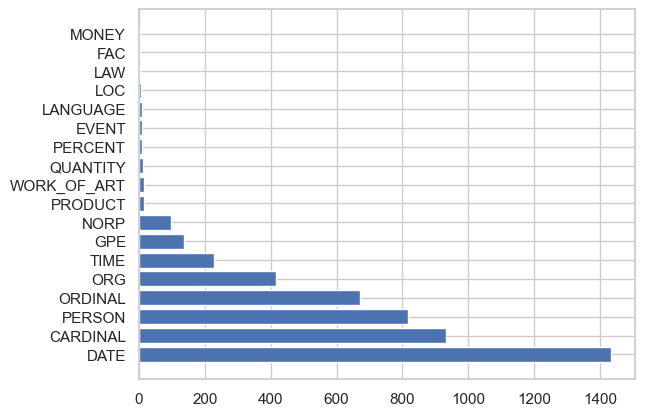

In [44]:
#Import library
import spacy
nlp = spacy.load("en_core_web_sm")
x_train_0 = train_set[train_set['label'] == 0]

# Human Gemer
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=x_train_0['text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()
x,y=map(list,zip(*count))
plt.barh(x,y)

plt.show()

Chatgpt Generated

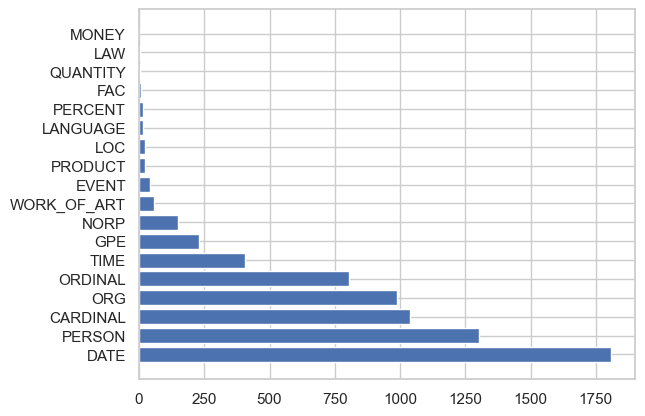

In [45]:
#Import library
nlp = spacy.load("en_core_web_sm")
x_train_1 = train_set[train_set['label'] == 1]

# Human Gemer
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=x_train_1['text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()
x,y=map(list,zip(*count))
plt.barh(x,y)

plt.show()

Hvorfor har vi named enty med?

Vi kan se at chattens text er ca 2 gange så mange tegn som menneskeskrevet,
vi kan dog også se at mængden af named entities er mindre en dobbelt så meget -> kunne tyde på chatten gør mere brug adjectiver 

## Part of speech

- Noun (NN)- Joseph, London, table, cat, teacher, pen, city

- Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is

- Adjective(JJ)- beautiful, happy, sad, young, fun, three

- Adverb(RB)- slowly, quietly, very, always, never, too, well, tomorrow

- Preposition (IN)- at, on, in, from, with, near, between, about, under

- Conjunction (CC)- and, or, but, because, so, yet, unless, since, if

- Pronoun(PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this

- Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

In [46]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## POS tags for human generated text

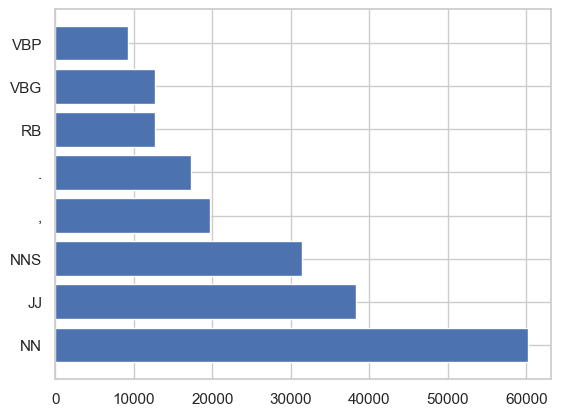

In [47]:
#Looking for the most common POS tags for human generated text
def pos(text):
    pos=nltk.pos_tag(nltk.word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

x_train_0 = train_set[train_set['label'] == 0]
tags=x_train_0['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(8))))
plt.barh(x,y)

plt.show()

## POS tags for human AI GENERATED TEXT

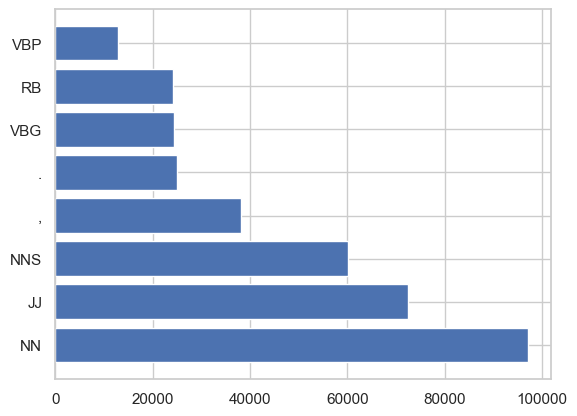

In [48]:
#Looking for the most common POS tags for human generated text
def pos(text):
    pos=nltk.pos_tag(nltk.word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

x_train_1 = train_set[train_set['label'] == 1]
tags=x_train_1['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(8))))
plt.barh(x,y)

plt.show()

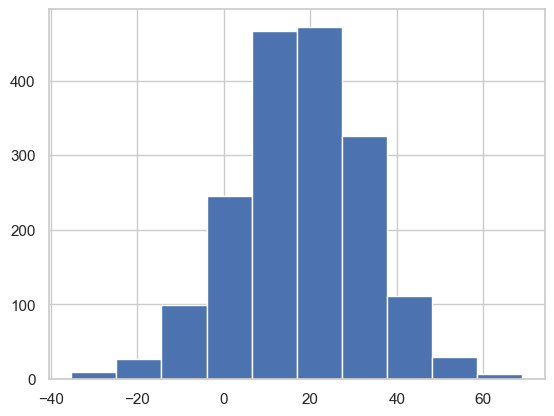

In [49]:
# Human text
x_train_0['text'].apply(lambda x : flesch_reading_ease(x)).hist()

plt.show()

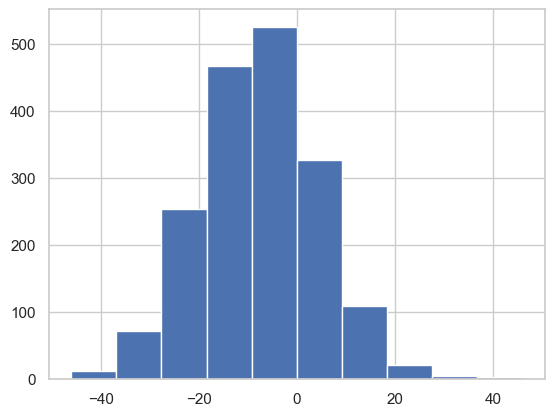

In [50]:
# Ai generated text
x_train_1['text'].apply(lambda x : flesch_reading_ease(x)).hist()

plt.show()

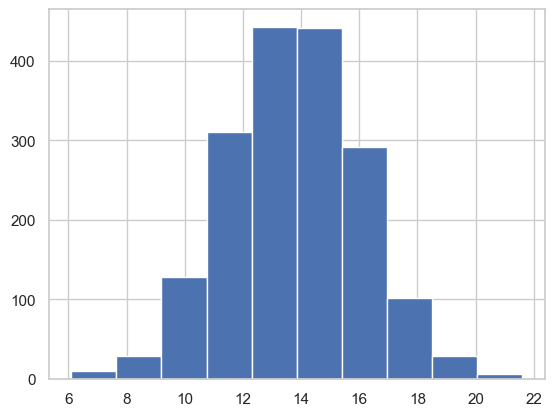

In [51]:
# humain
x_train_0['text'].apply(lambda x : flesch_kincaid_grade(x)).hist()

plt.show()

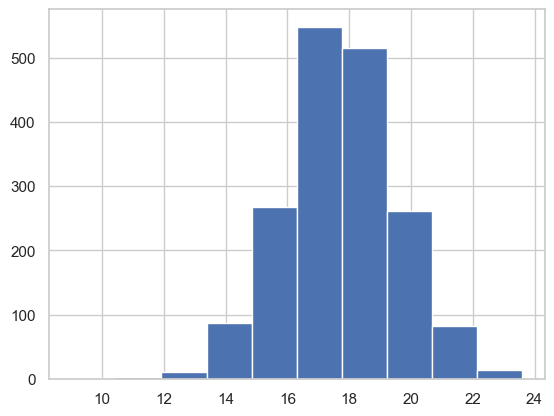

In [52]:
# ai generated text
x_train_1['text'].apply(lambda x : flesch_kincaid_grade(x)).hist()

plt.show()

### Wordcloud

In [53]:
stop=set(nltk.corpus.stopwords.words('english'))

In [54]:
# Human
corpus_human = []
new1 = x_train_0['text'].str.split().tolist()
corpus_human = [word for sublist in new1 for word in sublist]

dic_human = {}
for word in corpus_human:
    if word in stop:
        dic_human[word] = dic_human.get(word, 0) + 1


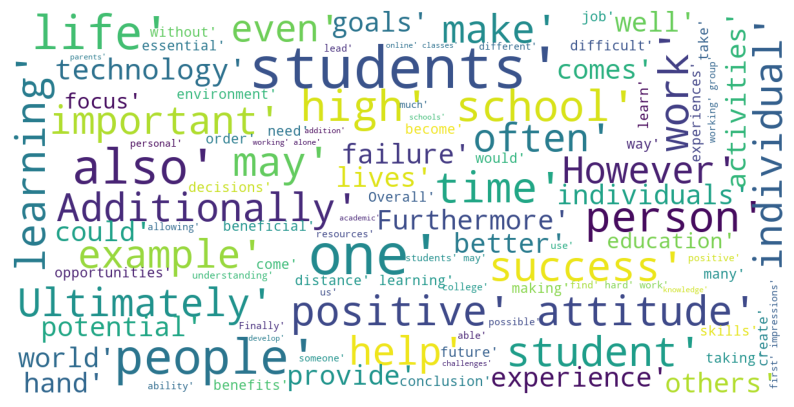

In [55]:

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus_human)

In [56]:
# LLM
corpus_LLM = []
new2 = x_train_1['text'].str.split().tolist()
corpus_LLM = [word for sublist in new2 for word in sublist]

dic_LLM = {}
for word in corpus_LLM:
    if word in stop:
        dic_LLM[word] = dic_LLM.get(word, 0) + 1

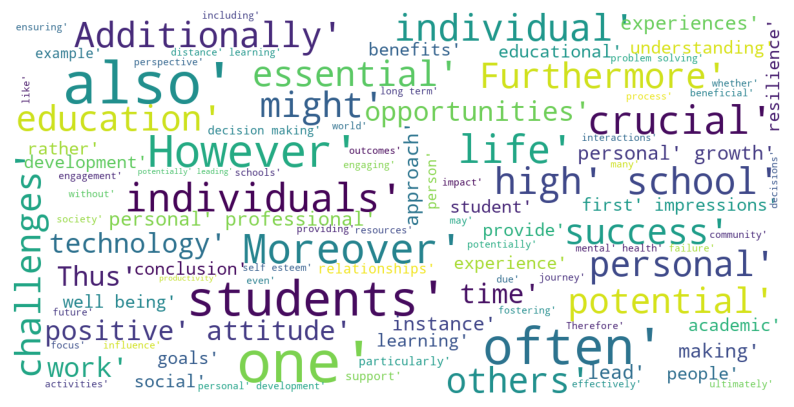

In [57]:
show_wordcloud(corpus_LLM)

In [58]:


'''
Lad være at slette det her. Har skrkevt de så den ikke forsætter med at køre 
'''

'\nLad være at slette det her. Har skrkevt de så den ikke forsætter med at køre \n'

We will now create the preprocessing steps with Word2vec such that our models have 
an input that they can use. 

In [59]:
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

# Function to preprocess text
def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_stop])

# Function to create word2vec representations and prepare data
def data_pipeline(df):
    df['processed_text'] = df['text'].map(preprocess_text)
    df['word2vec_doc'] = df['processed_text'].apply(lambda text: nlp(text).vector) #Lambda x is applying function to every element in the column
    if 'label' in df.columns:
        X = df['word2vec_doc'].apply(pd.Series)
        y = df['label']
        return X, y
    else:
        X = df['word2vec_doc'].apply(pd.Series)
        return X




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.4 MB/s eta 0:00:0000:0100:01



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [60]:
train_data, test_data = train_test_split(train_set, stratify=train_set.label, random_state=10, test_size=0.2)

# Process the data
X_train_with_word2vec, y_train_with_word2vec = data_pipeline(train_data)
X_test_with_word2vec, y_test_with_word2vec = data_pipeline(test_data)

# Normalize the data to ensure no negative values
scaler = MinMaxScaler()
X_train_with_word2vec = scaler.fit_transform(X_train_with_word2vec)
X_test_with_word2vec = scaler.transform(X_test_with_word2vec)

# Train the model
model_nb = MultinomialNB()
model_nb.fit(X_train_with_word2vec, y_train_with_word2vec)

# Predict and evaluate
y_test_pred = model_nb.predict_proba(X_test_with_word2vec)[:, 1]
print(classification_report(y_test_with_word2vec, y_test_pred > 0.5))

              precision    recall  f1-score   support

           0       0.87      0.75      0.80       358
           1       0.78      0.89      0.83       359

    accuracy                           0.82       717
   macro avg       0.82      0.82      0.81       717
weighted avg       0.82      0.82      0.81       717



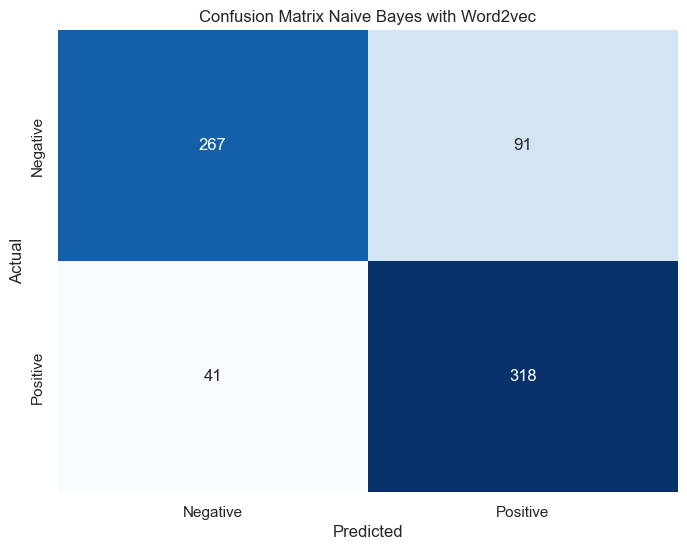

In [61]:
# Confusion matrix
conf_mat = confusion_matrix(y_test_with_word2vec, y_test_pred > 0.5)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Naive Bayes with Word2vec')
plt.show()

In [62]:
# Define a basic neural network model
model = Sequential()

# Add layers to the model
model.add(Dense(256, activation='relu', name="Dense_256", input_dim=X_train_with_word2vec.shape[1]))
model.add(Dropout(0.5, name="dropout_1"))
model.add(Dense(64, activation='relu', name="Dense_64", kernel_regularizer=l2()))
model.add(Dropout(0.5, name="dropout_2"))
model.add(Dense(1, activation='sigmoid', name="output"))

# Summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model
model.fit(X_train_with_word2vec, y_train_with_word2vec, batch_size=32,epochs=30, validation_data=(X_test_with_word2vec, y_test_with_word2vec), callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_256 (Dense)           (None, 256)               77056     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Dense_64 (Dense)            (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 93,569
Trainable params: 93,569
Non-trainable params: 0
_________________________________________________________________


2024-05-30 19:32:28.848487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
90/90 [==============================] - 3s 10ms/step - loss: 1.7154 - accuracy: 0.5309 - val_loss: 1.6332 - val_accuracy: 0.7127
Epoch 2/30
90/90 [==============================] - 0s 3ms/step - loss: 1.6161 - accuracy: 0.5606 - val_loss: 1.5518 - val_accuracy: 0.7545
Epoch 3/30
90/90 [==============================] - 0s 2ms/step - loss: 1.5307 - accuracy: 0.6241 - val_loss: 1.4638 - val_accuracy: 0.7894
Epoch 4/30
90/90 [==============================] - 1s 8ms/step - loss: 1.4572 - accuracy: 0.6461 - val_loss: 1.3839 - val_accuracy: 0.7922
Epoch 5/30
90/90 [==============================] - 0s 5ms/step - loss: 1.3794 - accuracy: 0.6796 - val_loss: 1.3022 - val_accuracy: 0.7978
Epoch 6/30
90/90 [==============================] - 1s 8ms/step - loss: 1.3106 - accuracy: 0.7058 - val_loss: 1.2244 - val_accuracy: 0.8187
Epoch 7/30
90/90 [==============================] - 1s 7ms/step - loss: 1.2411 - accuracy: 0.7211 - val_loss: 1.1574 - val_accuracy: 0.8187
Epoch 8/30
90/90 [=

Epoch 1/30
90/90 [==============================] - 1s 7ms/step - loss: 0.5021 - accuracy: 0.8876 - val_loss: 0.4829 - val_accuracy: 0.8940
Epoch 2/30
90/90 [==============================] - 1s 7ms/step - loss: 0.4939 - accuracy: 0.8897 - val_loss: 0.4676 - val_accuracy: 0.8954
Epoch 3/30
90/90 [==============================] - 0s 5ms/step - loss: 0.4784 - accuracy: 0.8974 - val_loss: 0.4619 - val_accuracy: 0.8982
Epoch 4/30
90/90 [==============================] - 0s 4ms/step - loss: 0.4714 - accuracy: 0.8921 - val_loss: 0.4613 - val_accuracy: 0.8968
Epoch 5/30
90/90 [==============================] - 0s 5ms/step - loss: 0.4666 - accuracy: 0.8946 - val_loss: 0.4392 - val_accuracy: 0.9024
Epoch 6/30
90/90 [==============================] - 0s 4ms/step - loss: 0.4451 - accuracy: 0.9005 - val_loss: 0.4286 - val_accuracy: 0.9024
Epoch 7/30
90/90 [==============================] - 1s 6ms/step - loss: 0.4352 - accuracy: 0.8946 - val_loss: 0.4250 - val_accuracy: 0.9052
Epoch 8/30
90/90 [==

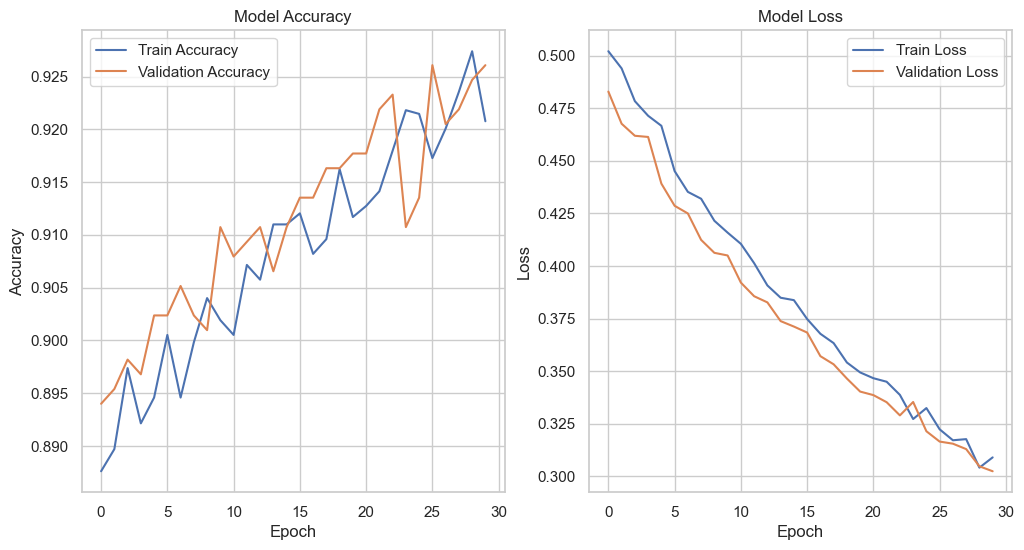

In [63]:
history = model.fit(X_train_with_word2vec, y_train_with_word2vec,batch_size=32, epochs=30, validation_data=(X_test_with_word2vec, y_test_with_word2vec), callbacks=[early_stopping])

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

23/23 [==============================] - 1s 1ms/step


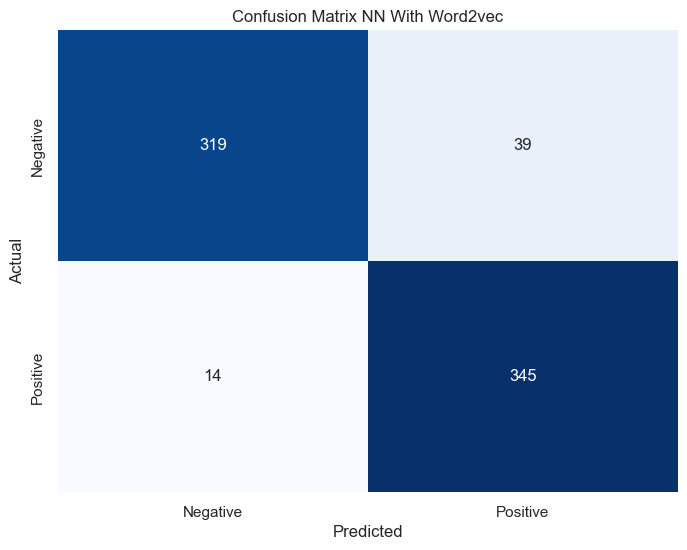

In [64]:
y_pred = model.predict(X_test_with_word2vec)
y_pred_binary = (y_pred > 0.5).astype(int)
conf_mat = confusion_matrix(y_test_with_word2vec, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix NN With Word2vec')
plt.show()

In [65]:
print(classification_report(y_test_with_word2vec, y_pred_binary))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       358
           1       0.90      0.96      0.93       359

    accuracy                           0.93       717
   macro avg       0.93      0.93      0.93       717
weighted avg       0.93      0.93      0.93       717



ROC AUC Score: 0.9260321190146434


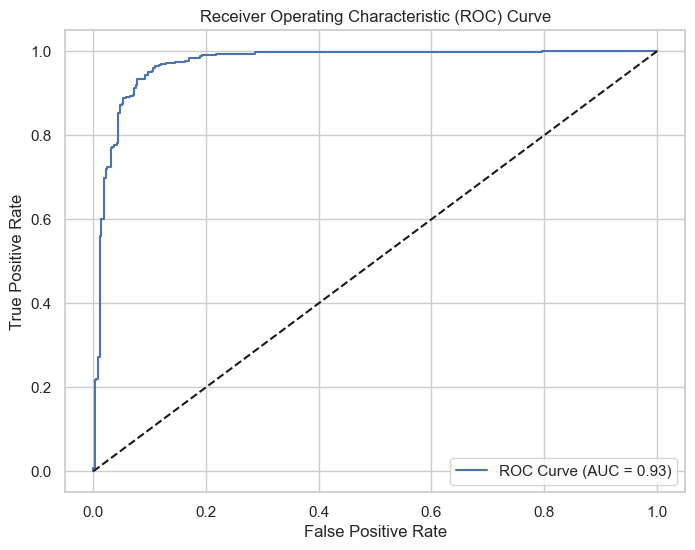

In [66]:
roc_auc = roc_auc_score(y_test_with_word2vec, y_pred_binary)
print("ROC AUC Score:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test_with_word2vec,  y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Load BERT


In [67]:
# Load BERT model and preprocessing
bert_encoder = hub.KerasLayer("./bert/bert-en-uncased-l-12-h-128-a-2", trainable=True)
bert_preprocess = hub.KerasLayer("./bert/en-uncased-preprocess")


### Bert with Naive Bayes

In [68]:
def preprocess_text_with_bert(text):
    preprocessed_text = bert_preprocess([text])
    return bert_encoder(preprocessed_text)['pooled_output'].numpy()[0]

# Function to create BERT representations and prepare data
def data_pipeline_with_bert(df):
    df['bert_embedding'] = df['text'].apply(preprocess_text_with_bert)
    if 'label' in df.columns:
        X = pd.DataFrame(df['bert_embedding'].tolist())
        y = df['label']
        return X, y
    else:
        X = pd.DataFrame(df['bert_embedding'].tolist())
        return X


In [69]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(train_set, stratify=train_set.label, random_state=10, test_size=0.2)

# Process the data using BERT embeddings
X_train_with_bert, y_train_with_bert = data_pipeline_with_bert(train_data)
X_test_with_bert, y_test_with_bert = data_pipeline_with_bert(test_data)


In [70]:
# Normalize the data to ensure no negative values
scaler = MinMaxScaler()
X_train_with_bert = scaler.fit_transform(X_train_with_bert)
X_test_with_bert = scaler.transform(X_test_with_bert)


In [71]:
# Train the model
model_nb = MultinomialNB()
model_nb.fit(X_train_with_bert, y_train_with_bert)

# Predict and evaluate
y_test_pred = model_nb.predict_proba(X_test_with_bert)[:, 1]
print(classification_report(y_test_with_bert, y_test_pred > 0.5))


              precision    recall  f1-score   support

           0       0.78      0.73      0.75       358
           1       0.75      0.79      0.77       359

    accuracy                           0.76       717
   macro avg       0.76      0.76      0.76       717
weighted avg       0.76      0.76      0.76       717



### BERT with Neural Network

In [72]:
X_train, X_test, y_train, y_test = train_test_split(train_set["text"], train_set["label"], test_size=0.15, random_state=42, stratify=train_set["label"])

In [73]:
text_input = Input(shape=(), dtype=tf.string,name='Text')
Preprocessor = bert_preprocess(text_input)
output = bert_encoder(Preprocessor)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


TTR ( type ttoke n)

In [74]:
# Neural network layers
x = Dense(256 , activation='relu',name="Dense_256" )(output["pooled_output"])
x = Dropout(0.5, name="dropout_1")(x)
x = Dense(64, activation='relu', name="Dense_64", kernel_regularizer=l2())(x)
x = Dropout(0.5, name="dropout_3")(x)
outputs = Dense(1, activation='sigmoid', name="output")(x)

# Use inputs and outputs to construct a final model
model = Model(inputs=[text_input], outputs = outputs)

In [75]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['Text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [76]:

model.compile(optimizer=Adam(learning_rate=5e-5),
              loss="binary_crossentropy",
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/3


96/96 [==============================] - 343s 3s/step - loss: 1.5294 - accuracy: 0.7063 - val_loss: 1.1462 - val_accuracy: 0.9498
Epoch 2/3
96/96 [==============================] - 271s 3s/step - loss: 1.1411 - accuracy: 0.9402 - val_loss: 1.0084 - val_accuracy: 0.9740
Epoch 3/3
96/96 [==============================] - 267s 3s/step - loss: 0.9904 - accuracy: 0.9724 - val_loss: 1.1042 - val_accuracy: 0.9126


Epoch 1/3


96/96 [==============================] - 259s 3s/step - loss: 0.8918 - accuracy: 0.9859 - val_loss: 0.9048 - val_accuracy: 0.9703
Epoch 2/3
96/96 [==============================] - 255s 3s/step - loss: 0.8274 - accuracy: 0.9898 - val_loss: 0.8130 - val_accuracy: 0.9814
Epoch 3/3
96/96 [==============================] - 265s 3s/step - loss: 0.7627 - accuracy: 0.9915 - val_loss: 0.7683 - val_accuracy: 0.9796


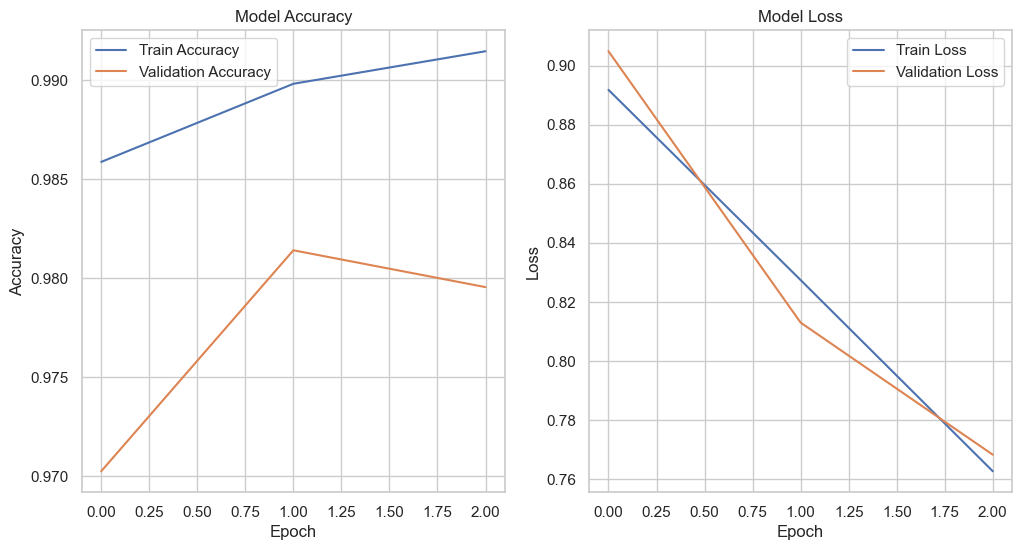

In [77]:
# Train the model and store the history
history = model.fit(X_train, y_train, epochs=3,batch_size=32 ,validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

17/17 [==============================] - 17s 811ms/step


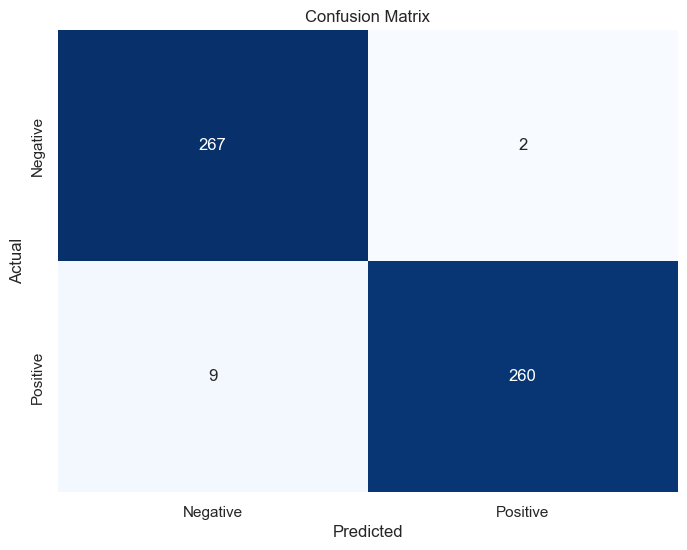

In [78]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

conf_mat = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [82]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       269
           1       0.99      0.97      0.98       269

    accuracy                           0.98       538
   macro avg       0.98      0.98      0.98       538
weighted avg       0.98      0.98      0.98       538



In [79]:
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, y_pred_binary)
print("ROC AUC Score:", roc_auc)

F1 Score: 0.9792843691148776
ROC AUC Score: 0.9795539033457249


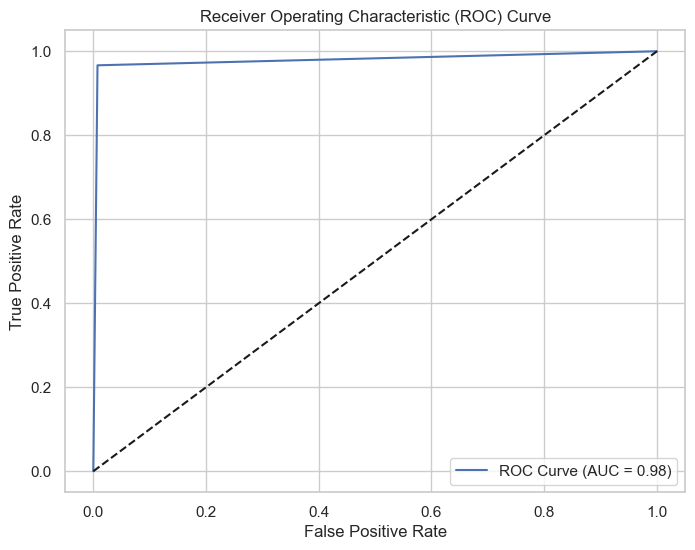

In [80]:
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_binary)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [81]:
X_test

1910    First impressions lasting impact . often assoc...
1532    definitive answer question whether attending c...
3561    integration healthier lunch menu schools repre...
1827    Year-round schooling , though may appear benef...
2875    Online classes traditional classroom-based edu...
                              ...                        
1200    Staying active important part achieving sense ...
185     Choosing career still high school poses signif...
1756    Success often achieved hard work , dedication ...
1588    One major benefits able attend school home inc...
969     Thomas Jefferson , one Founding Fathers United...
Name: text, Length: 538, dtype: object